In [2]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from PIL import Image
import os
import shutil
import subprocess
from tqdm import tqdm

from utils.shapefiles import sampleShapefileLocations
from utils.divtree_gen import *
from utils.seqdata_gen import *
from utils.seq2demodst import *
from utils.coords import *
from utils.noise import *
from utils.metrics import *
from analysis.peaksdata import *

from utils.treeEditDistance import *
import math

%matplotlib inline
mpl.rcParams['image.cmap'] = 'terrain'

In [3]:
np.random.seed(42)

In [1]:
promEpsilon   = 30   # m,  minimum prominence threshold in the analysis
diskRadius    = 30   # km, used for the analysis to normalize histograms 
globalMaxElev = 9000 # m,  any value larger than any other peak elevation, used internally as initialization and undefineds

terrainUnitKm  = 90  # km, size of terrain
km2pixels = 1000/30  # 30 m/pixel

# process each region (note: it takes a long time!)
regionShapesDir = '../data/regionShapes'
regionPeaksDir = 'data/regionPeaks'
regionSeqsDir = 'data/regionSeqs'
regionTreeSeqsDir = 'data/regionTreeSeqs'


regionShapes = ['andes_peru.shp']

In [4]:
#regionName, filterCoords = 'pyrenees', [42.5893, 0.9377] # pyrenees: aiguestortes
#regionName, filterCoords = 'alps', [45.8325,  7.0]  # mont blanc
#regionName, filterCoords = 'alps', [44.8742,  6.5]  # ecrins
#regionName, filterCoords = 'alps', [46.4702, 11.9492] # dolomites
#regionName, filterCoords = 'alps', [46.0159, 7.74318] # valais
#regionName, filterCoords = 'sahara', [30.38, 8.69] # sahara dunes
#regionName, filterCoords = 'andes_chile', [-21.4483, -68.0708] # chile
#regionName, filterCoords = 'karakoram', [35.8283, 76.3608] # karakoram
#regionName, filterCoords = 'colorado', [39.0782,-106.6986] # colorado
#regionName, filterCoords = 'yangshuo', [24.9917, 110.4617] # yangshuo
#regionName, filterCoords = 'himalaya', [28.7150, 84.2000] # himalaya: annapurna
#regionName, filterCoords = 'himalaya', [27.8575, 86.8267] # himalaya: everest
#regionName, filterCoords = 'norway', [62.1167, 6.8075] # norway
#regionName, filterCoords = 'alaska', [62.9500, -151.0908] # alaska
#regionName, filterCoords = 'patagonia', [-50.8925, -73.1533] # patagonia
#regionName, filterCoords = 'andes_aconcagua', [-32.6533, -70.0108] # aconcagua
regionName, filterCoords = 'andes_peru', [-9.0874, -77.5737] # huascaran
#regionName, filterCoords = 'rockies', [50.8003, -116.29517] # canadian rockies
#regionName, filterCoords = 'appalachians', [35.3855, -83.2380] # appalachians
#regionName, filterCoords = 'highlands', [56.9667, -3.5917] # highlands

peaksFile = '../data/regionPeaks/%s.csv' % regionName

filterRadius = 90 # km
filterHWidth = [km2deg(filterRadius), km2deg(filterRadius, filterCoords[0])]
print("filter scope: ",filterCoords[0] - filterHWidth[0], filterCoords[0] + filterHWidth[0],
      filterCoords[1] - filterHWidth[1], filterCoords[1] + filterHWidth[1])

# read peaks file and filter region of interest
df = pd.read_csv(peaksFile)

filat = np.logical_and(df['latitude']  > filterCoords[0] - filterHWidth[0], 
                       df['latitude'] < filterCoords[0] + filterHWidth[0])
filon = np.logical_and(df['longitude'] > filterCoords[1] - filterHWidth[1], 
                       df['longitude'] < filterCoords[1] + filterHWidth[1])
df = df[np.logical_and(filat, filon)]

print('Peaks:', df.shape[0])

filter scope:  -9.89724774862326 -8.277552251376742 -78.39384170503196 -76.75355829496804
Peaks: 4314


In [5]:
print(df['longitude'].mean())

-77.39135927213722


In [6]:
diskRadius = 30
sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, 'andes_peru.shp'), diskRadius)
print(regionName, ": ", len(sampleLocations), "samples")
length = []
for di,diskCenter in tqdm(enumerate(sampleLocations)):
    peak = filterPeaksHaversineDist(df, diskCenter, diskRadius)
    length.append(len(peak))

plt.hist(length, bins=6, fc='b')
plt.show()

ShapefileException: Unable to open data/regionShapes/andes_peru.dbf or data/regionShapes/andes_peru.shp.

### Visualize the peaks

In [ ]:
# compute distributions
df = addExtraColumns(df)
fig = plt.figure(figsize=(5,5))
_ = plt.scatter(df['longitude'], df['latitude'], marker='^', 
                s=20*df['elev'].values/df['elev'].values.max(), c=df['elev'].values/df['elev'].values.max())

### Generrate Sequence

In [ ]:
import pickle
bfsseqdata_file_name = 'HMM_Seq_bfs.data'
dfsseqdata_file_name = 'HMM_Seq_dfs.data'
diskRadius = 30
if os.path.exists(bfsseqdata_file_name) and os.path.exists(dfsseqdata_file_name):
    with open(bfsseqdata_file_name, 'rb') as seqdata_file:
        bfsTrees = pickle.load(seqdata_file)
    with open(dfsseqdata_file_name, 'rb') as seqdata_file:
        dfsTrees = pickle.load(seqdata_file)
else:
    print(os.path.join(regionShapesDir, 'andes_peru.shp'))
    sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, 'andes_peru.shp'), diskRadius)
    print(regionName, ": ", len(sampleLocations), "samples")
    bfsTrees = []
    dfsTrees = []
    # compute sequences
    for di,diskCenter in tqdm(enumerate(sampleLocations)):
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        if peaks.shape[0] < 50:
            continue
        rootNode = genDivideTree(peaks)
        seqOfTree_bfs = genFullSeqHMM(rootNode, isDFS=False)
        seqOfTree_dfs = genFullSeqHMM(rootNode, isDFS=True)
        bfsTrees.append(seqOfTree_bfs)
        dfsTrees.append(seqOfTree_dfs)

    with open(bfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(bfsTrees, seqdata_file)
    with open(dfsseqdata_file_name, 'wb') as seqdata_file:
        pickle.dump(dfsTrees, seqdata_file)

# bfsseqdata_file_name = 'HMM_Seq_bfs_big.data'
# dfsseqdata_file_name = 'HMM_Seq_dfs_big.data'

# if os.path.exists(bfsseqdata_file_name) and os.path.exists(dfsseqdata_file_name):
#     with open(bfsseqdata_file_name, 'rb') as seqdata_file:
#         bfsTreeBig = pickle.load(seqdata_file)
#     with open(dfsseqdata_file_name, 'rb') as seqdata_file:
#         dfsTreeBig = pickle.load(seqdata_file)
# else:
#     rootNode = genDivideTree(df)
#     bfsTreeBig = genFullSeqHMM(rootNode, isDFS=False)
#     dfsTreeBig = genFullSeqHMM(rootNode, isDFS=True)

#     with open(bfsseqdata_file_name, 'wb') as seqdata_file:
#         pickle.dump(bfsTreeBig, seqdata_file)
#     with open(dfsseqdata_file_name, 'wb') as seqdata_file:
#         pickle.dump(dfsTreeBig, seqdata_file)

In [ ]:
def drawResult(edges):
    X = []
    Y = []
    for v, w in edges:
        X.append([v[0], w[0]])
        Y.append([v[1], w[1]])
    for i in range(len(X)):
        plt.plot(X[i], Y[i], color='r')

def drawResultOrder(peakList):
    X = []
    Y = []
    for i in range(len(peakList)-1):
        X.append([peakList[i][0], peakList[i+1][0]])
        Y.append([peakList[i][1], peakList[i+1][1]])
    for i in range(len(X)):
        plt.plot(X[i], Y[i], color='r')

### define model (HMM)

In [10]:
from hmmlearn import hmm

In [11]:
# little dataset
lengths = []
bfsTrees_flat = []
dfsTrees_flat = []
for i, seq in enumerate(bfsTrees):
    lengths.append(len(seq))
    bfsTrees_flat += bfsTrees[i]
    dfsTrees_flat += dfsTrees[i]


In [54]:
gmm = hmm.GMMHMM(2, 5)
# gmm = hmm.GaussianHMM(4)
gmm = gmm.fit(dfsTrees_flat, lengths)
gmm.score(dfsTrees_flat, lengths)

# ext_set = []
# ext_length = []
# for i in range(10):
#     ext_set += dfsTreeBig
#     ext_length.append(len(dfsTreeBig))
# gmm = gmm.fit(ext_set, ext_length)
# gmm.score(dfsTreeBig)

-97197.37304464265

In [55]:
print(gmm.get_stationary_distribution())

[0.72576958 0.27423042]


## Test prediction

### Prediction

In [56]:
predictLen = 100
pointlist = [[df.mean()['longitude'], df.mean()['latitude'], df.max()['elevation in feet'],df.mean()['prominence in feet']]]
deltaslist = [[0.0, 0.0, 0.0, 0.0]]
plt.rcParams['figure.figsize'] = (6.0, 4.0)
predict = gmm.sample(predictLen)[0]
for i in range(predictLen):
    deltas = predict[i]
    deltaslist.append(deltas)
    point = [0,0,0,0]
    for i in range(4):
        point[i] = pointlist[-1][i] + deltas[i]
    pointlist.append(point)



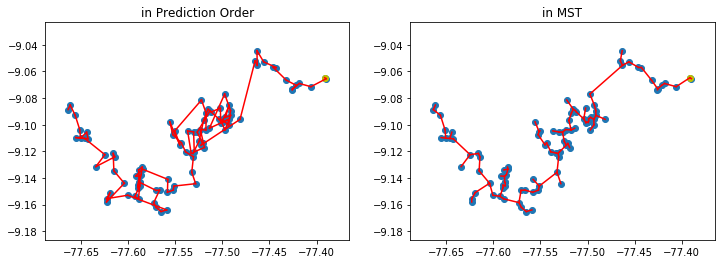

In [57]:
apointlist = np.array(pointlist)
peaks = [list(p) for p in apointlist[:, :2]]
edges = getTreeHMC(peaks)
plt.rcParams['figure.figsize'] = (12.0, 4.0)
# in order
plt.subplot(121)
plt.scatter(apointlist[:,0], apointlist[:,1])
drawResultOrder(apointlist)
plt.scatter(apointlist[0,0], apointlist[0,1], c='y')
plt.title('in Prediction Order')
# in MST
plt.subplot(122)
plt.scatter(apointlist[:,0], apointlist[:,1])
drawResult(edges)
plt.scatter(apointlist[0,0], apointlist[0,1], c='y')
plt.title('in MST')
plt.savefig('../note.assets/hmm_25_dfs.png')
plt.show()


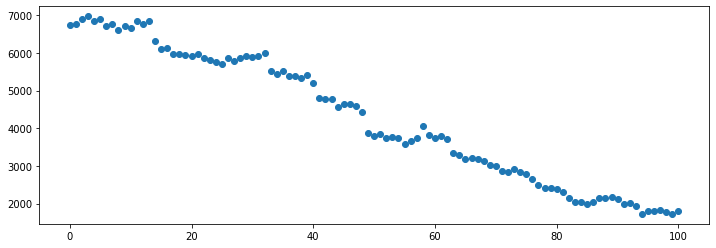

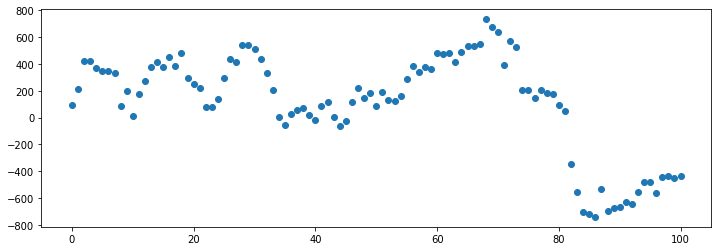

In [58]:
xx = [i for i in range(predictLen+1)]
elepre = [feet2m(apointlist[i][2]) for i in range(predictLen+1)]
propre = [feet2m(apointlist[i][3]) for i in range(predictLen+1)]
plt.scatter(xx, elepre)
# plt.savefig('../note.assets/hmm_64_ele_exm.png')
plt.show()
plt.scatter(xx, propre)
# plt.savefig('../note.assets/hmm_64_pro_exm.png')


## Evaluation

In [59]:
# compute distributions
df = addExtraColumns(df)
distributions = computeDistributions(df, diskRadius)

In [60]:
barColor  = (216/255, 226/255, 238/255, 1.0)
edgeColor = (137/255, 151/255, 168/255, 1.0)

def printHistogramsDistances(hbins, hReal, hSynth):
    hdiff = np.abs(hReal - hSynth)
    print('Max', np.max(hdiff), 'Sum', np.sum(hdiff), 'Avg', np.mean(hdiff))
    print('EMD', np.diff(hbins)[0]*np.abs(np.cumsum(hReal) - np.cumsum(hSynth)).sum())
    
def histogramsComparison(distribution, synthesisValues):
    hbins  = distribution['bins']
    hmids  = distribution['x']
    hReal  = distribution['hist']
    hSynth = histogramFromBins(synthesisValues, hbins, frequencies=False)
    hNorm  = np.round(synthesisValues.size * hReal/hReal.sum())

    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(131)
    _ = ax.bar (hmids, hSynth, width=np.diff(hbins), color=barColor, edgecolor=edgeColor)
    _ = ax.plot(hmids, hNorm, color='r')

    ax = fig.add_subplot(132)
    _ = ax.bar (hmids, hNorm, width=np.diff(hbins), color='g')
    _ = ax.plot(hmids, hNorm, color='r')
    
    printHistogramsDistances(hbins, hReal/hReal.sum(), hSynth/hSynth.sum())
    print('Per bin differences (synthesis - target)')
    print(hSynth - hNorm)

def kldistance(distribution, synthesisValues):
    hbins  = distribution['bins']
    hmids  = distribution['x']
    hReal  = distribution['hist']
    hSynth = histogramFromBins(synthesisValues, hbins, frequencies=False)
    hNorm  = np.round(synthesisValues.size * hReal/hReal.sum())
    # smooth
    hNorm += 1
    hSynth += 1
    phNorm = hNorm / sum(hNorm)
    phSynth = hSynth / sum(hSynth)
    distance = 0
    for i in range(len(phNorm)):
        distance += phSynth[i]*(math.log(phSynth[i]) - math.log(phNorm[i]))
    return distance

Max 0.10477515067222995 Sum 1.4123530572806933 Avg 0.016813726872389207
EMD 989.9156327315627
Per bin differences (synthesis - target)
[  0.   0.   0.   0.   0.   0.   0.  -1.  -1.  -1.  -1.  -1.   0.  -1.
  -1.   0.   0.   5.   2.   2.   4.   5.  -1.   2.   3.   0.   1.   0.
   2.   1.   1.   2.   1.   0.  -1.   0.   0.   4.   0.  -5.  -4.  -6.
  -8. -11.  -7.  -6.  -5.  -3.  -2.  -2.  -2.  -1.   0.   2.   1.   1.
  -1.   3.   5.   8.   1.   1.   0.   1.   0.   0.   2.   6.   5.   1.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
kl-divergence:  0.5518457839992101


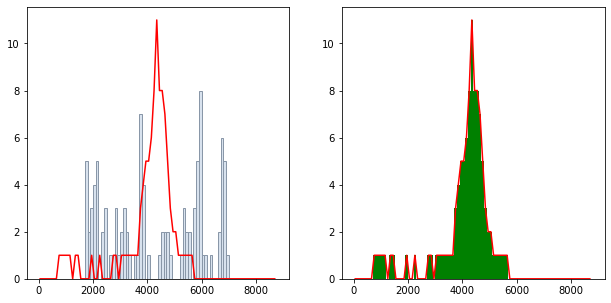

In [61]:
histogramsComparison(distributions['elevation'], np.array(elepre))
plt.savefig('../note.assets/hmm_25_ele.png')
print('kl-divergence: ',kldistance(distributions['elevation'], np.array(elepre)))

Max 0.3053207802860098 Sum 1.1906494062265969 Avg 0.0290402294201609
EMD 206.22035590742138
Per bin differences (synthesis - target)
[-33. -28.  -5.   1.   5.   3.   3.   8.   7.   6.   7.   1.   1.   1.
   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
kl-divergence:  0.6420304930445037


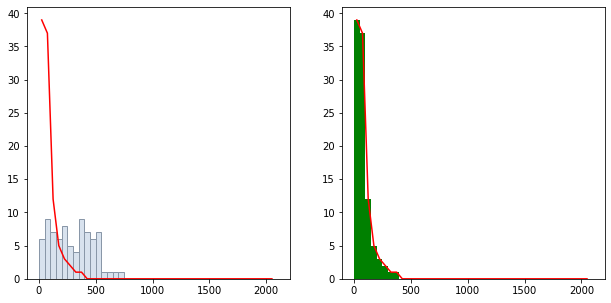

In [62]:
histogramsComparison(distributions['prominence'], np.array(propre))
plt.savefig('../note.assets/hmm_25_pro.png')
print('kl-divergence: ',kldistance(distributions['prominence'], np.array(propre)))

## Tree edit distance

In [ ]:
# choose one realtree as tree A
diskRadius = 30
sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, 'andes_peru.shp'), diskRadius)
for di,diskCenter in tqdm(enumerate(sampleLocations)):
        if len(peaks) == 0:
                continue
        peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
        rootNode = genDivideTree(peaks)
        break
A = buildTree(rootNode)

In [ ]:
# Predict one realtree as tree B
predictLen = len(peaks)
print(predictLen)
pointlist = [[peaks.mean()['longitude'], peaks.mean()['latitude'], peaks.max()['elevation in feet'],peaks.mean()['prominence in feet']]]
deltaslist = [[0.0, 0.0, 0.0, 0.0]]
predict = gmm.sample(predictLen)[0]
for i in range(predictLen):
    deltas = predict[i]
    deltaslist.append(deltas)
    point = [0,0,0,0]
    for i in range(4):
        point[i] = pointlist[-1][i] + deltas[i]
    pointlist.append(point)
broot = genDivideTreePredict(pointlist)
B = buildTree(broot)

# distance: 
time_1 = time.time()
dist = getDistance(A,B)
time_2 = time.time()

print(dist, time_2 - time_1)

In [ ]:
## search for the best parameters

In [ ]:

diskRadius = 30
sampleLocations = sampleShapefileLocations(os.path.join(regionShapesDir, 'andes_peru.shp'), diskRadius)
gridsearch = dict()
time_1 = time.time()
for n_state in range(2,10):
    for n_mix in range(1,n_state):
        try:
            gmm = hmm.GMMHMM(n_state, n_mix)
            # gmm = hmm.GaussianHMM(4)
            gmm = gmm.fit(bfsTrees_flat, lengths)
            # choose one realtree as tree A
            for di,diskCenter in tqdm(enumerate(sampleLocations)):
                # tree A
                peaks = filterPeaksHaversineDist(df, diskCenter, diskRadius)
                if len(peaks) == 0:
                    continue
                rootNode = genDivideTree(peaks)
                A = buildTree(rootNode)
                # tree B
                predictLen = len(peaks)
                for btime in range(3):
                    pointlist = [[peaks.mean()['longitude'], peaks.mean()['latitude'], 
                                    peaks.max()['elevation in feet'],peaks.mean()['prominence in feet']]]
                    deltaslist = [[0.0, 0.0, 0.0, 0.0]]
                    predict = gmm.sample(predictLen)[0]
                    for i in range(predictLen):
                        deltas = predict[i]
                        deltaslist.append(deltas)
                        point = [0,0,0,0]
                        for i in range(4):
                            point[i] = pointlist[-1][i] + deltas[i]
                        pointlist.append(point)
                    broot = genDivideTreePredict(pointlist)
                    B = buildTree(broot)
                    # distance
                    dist = getDistance(A,B)
                    print(n_state, n_mix, dist)
                    if (n_state, n_mix) not in gridsearch.keys():
                        gridsearch[(n_state, n_mix)] = dist/predictLen
                    else:
                        gridsearch[(n_state, n_mix)] += dist/predictLen
        except BaseException:
            continue

time_2 = time.time()
print(dist, time_2 - time_1)

In [ ]:
print('n_state, n_mix, edit_dist')
gridsearch_list = []
for k in gridsearch.keys():
    gridsearch_list.append([k[0], k[1], gridsearch[k]])
for n in sorted(gridsearch_list, key=lambda y: y[2]):
    print(n)